## Here are some basic plots from some data I use for research 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from dateutil.parser import parse
import plotly.express as px
import matplotlib.dates as mdates

In [43]:
# lets grab some files from seaflow
# read some light (par) and temperature data from sfl
name = 'TN397_740_740.sfl'
url = "https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/master/curated"
test = f'{url}/{name}'
req = requests.get(test).content
# decode and clean up data
df = pd.read_csv(io.StringIO(req.decode('utf-8')), sep="\t", lineterminator='\n')
df = df[df['LAT'].notnull()][['DATE', 'LAT','LON','SALINITY','PAR','OCEAN TEMP']]

# change column names to match before merge
df.columns= df.columns.str.lower()
df.rename(columns={'date':'time', 'ocean temp': 'temp'}, inplace=True)
# fix time and dtype
df['time'] = pd.DatetimeIndex(df['time'].apply(lambda x: parse(x))).tz_localize('UTC')

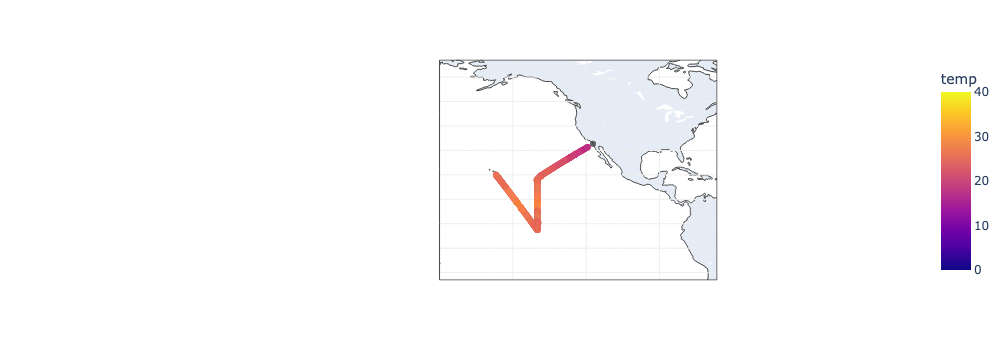

In [44]:
fig = px.scatter_geo(df, lat='lat',lon='lon',color='temp', opacity=0.1, range_color=[0,40])
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
# focus point
lat_foc = 22
lon_foc = -156.5
fig.update_layout(
        geo = dict(
            projection_scale=2, #this is kind of like zoom
            center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
        )
)

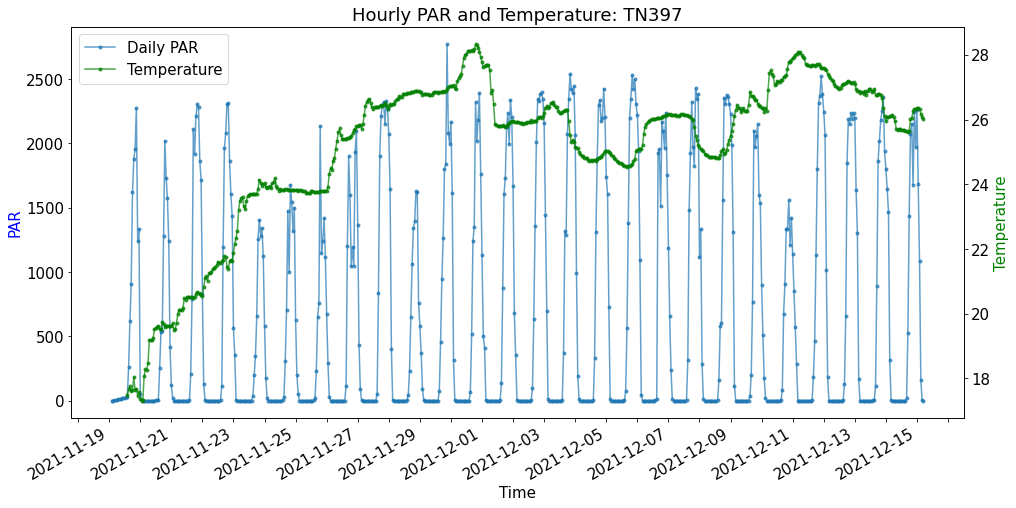

In [46]:
# group by to average par hourly
df_hourly = df.groupby([pd.Grouper(key="time", freq='1H')]).mean().reset_index()
# run a linear interpolation to fill in gaps
df_interp = df_hourly.set_index('time')
df_interp.index = pd.to_datetime(df_interp.index)
df_interp = df_interp.resample('1H').mean().interpolate(method='linear')

# show daily par values with temperature
fig, axs = plt.subplots(figsize=(16,8))
x = df_interp.index
y=df_interp['par']
y1 = df_interp['temp']
l1 = axs.plot(x,y, alpha=0.7, label='Daily PAR', marker='.')
axs.set_ylabel('PAR', c='b')
# plot temperature on secondary axis
ax0 = axs.twinx()
l2=ax0.plot(x,y1,alpha=0.7, c='g', label='Temperature', marker='.')
axs.set_xlabel('Time')
ax0.set_ylabel('Temperature', c='g')

# add legend
lns = l1+l2
labs = [l.get_label() for l in lns]
axs.legend(lns, labs, loc=0)
# add title
plt.title('Hourly PAR and Temperature: TN397')

# adjust x ticks
axs.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
for label in axs.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.rcParams.update({'font.size':15})
fig.savefig('example_plot.png')